<b>Download link:</b> https://www.kaggle.com/alxmamaev/flowers-recognition/home

<b>Summary:</b> Classifier built using resnet pretrained model

<b>ref: </b>https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [1]:
import torch
from torchvision import datasets, models, transforms

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])

In [4]:
import zipfile
zip = zipfile.ZipFile('datasets/flowers_.zip')
zip.extractall('datasets')

In [5]:
data_dir = 'datasets/flowers_'

In [7]:
image_datasets = {}

In [8]:
image_datasets['train'] = datasets.ImageFolder(data_dir + '/train', train_transform)

In [9]:
image_datasets['test'] = datasets.ImageFolder(data_dir + '/test', test_transform)

In [11]:
print("Training data size --> {}".format(len(image_datasets['train'])))
print("Test data size --> {}".format(len(image_datasets['test'])))

Training data size --> 3027
Test data size --> 1296


In [30]:
#examining our data

class_names = image_datasets['train'].classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [13]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 3027
     Root location: datasets/flowers_/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'test': Dataset ImageFolder
     Number of datapoints: 1296
     Root location: datasets/flowers_/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

In [14]:
dataloader = {}


In [15]:
dataloader['train'] = torch.utils.data.DataLoader(image_datasets['train'],
                                                 batch_size=8,
                                                 shuffle = True,
                                                 num_workers=4)

In [16]:
dataloader['test'] = torch.utils.data.DataLoader(image_datasets['test'],
                                                batch_size= 8,
                                                shuffle=True,
                                                num_workers=4)

In [17]:
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e58a60128>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e58a55278>}

In [18]:
inputs, labels = next(iter(dataloader['train']))

In [19]:
inputs.shape

torch.Size([8, 3, 224, 224])

In [20]:
labels.shape

torch.Size([8])

In [21]:
labels

tensor([4, 3, 0, 0, 4, 3, 4, 3])

In [22]:
import torchvision

inp = torchvision.utils.make_grid(inputs)

In [23]:
inp.shape

torch.Size([3, 228, 1810])

In [24]:
inp.max()

tensor(2.6400)

In [25]:
import numpy as np

np.clip(inp, 0, 1).max()

tensor(1.)

In [26]:
inp.numpy().transpose((1, 2, 0)).shape

(228, 1810, 3)

In [27]:
import matplotlib.pyplot as plt

plt.ion()

In [40]:
def image_show(inp, title = None):
    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize = (20, 6))
    plt.axis('off')
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)

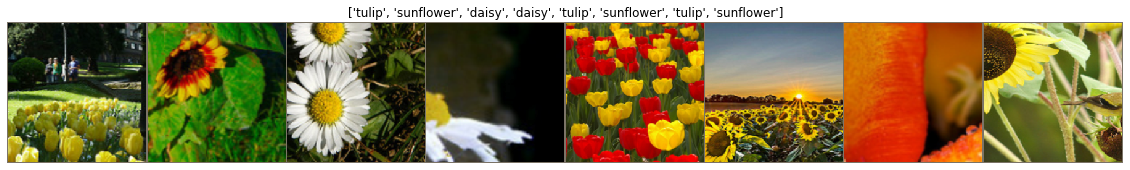

In [41]:
image_show(inp, title = [class_names[x] for x in labels])

## load the Resnet pretrained model

In [44]:
model = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\USER/.cache\torch\checkpoints\resnet18-5c106cde.pth


In [45]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [46]:
import torch.nn as nn

In [47]:
model.fc = nn.Linear(num_ftrs, 5)

In [48]:
criterion = nn.CrossEntropyLoss()

In [50]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(),
                     lr = 0.001,
                       momentum=0.9)

In [60]:
from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                      step_size = 7,
                                      gamma = 0.1)

In [52]:
def calculate_accuracy(phase, running_loss, running_corrects):
    
    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    return (epoch_loss, epoch_acc)

## Training phase

In [62]:
def phase_train(model, criterion, optimizer, scheduler):
    
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloader['train']:
        
        optimizer.zero_grad()
        
        
        with torch.set_grad_enabled(True):
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    
    calculate_accuracy('train', running_loss, running_corrects)

In [54]:
import copy

In [55]:
best_acc = 0.0

In [56]:
def phase_test(model, criterion, optimizer):
    
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    global best_acc
    
    for inputs, labels in dataloader['test']:
        
        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss, epoch_acc = calculate_accuracy('test', running_loss, running_corrects)
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    return best_model_wts
        

In [57]:
def build_model(model, criterion, optimizer, scheduler, num_epoch = 10):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch, num_epoch - 1))
        print("-" * 10)
        
        phase_train(model, criterion, optimizer, scheduler)
        best_model_wts = phase_test(model, criterion, optimizer)
        print()
        
    print("Best test Acc: {:4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model

In [63]:
model = build_model(model, criterion,
                   optimizer,
                   exp_lr_scheduler,
                   num_epoch=1)

Epoch 0/0
----------
train Loss: 0.7371 Acc: 0.7248
test Loss: 0.5222 Acc: 0.8194

Best test Acc: 0.819444


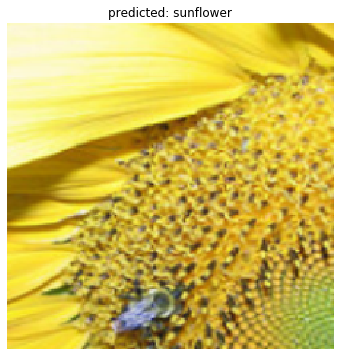

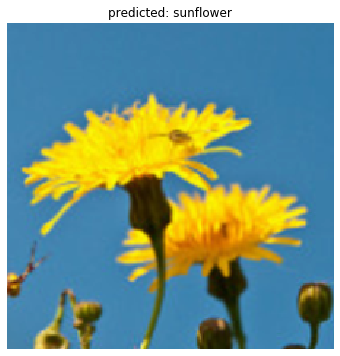

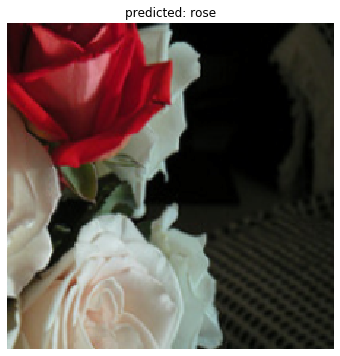

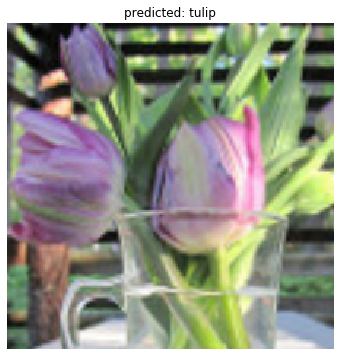

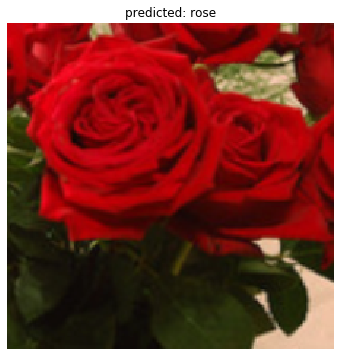

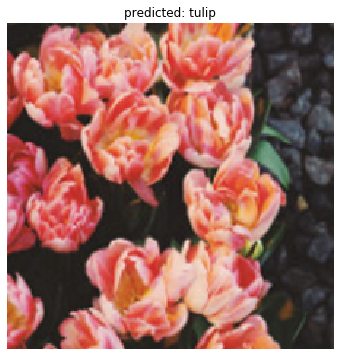

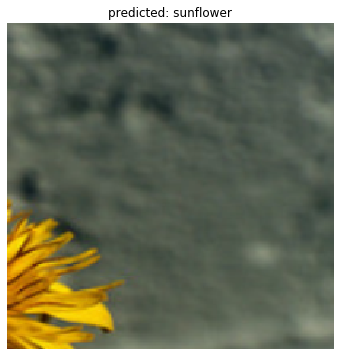

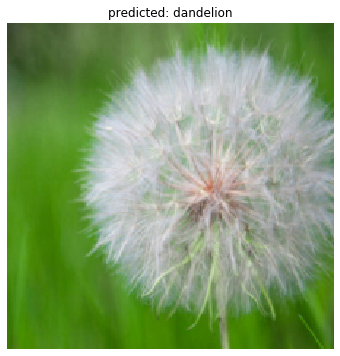

In [66]:
with torch.no_grad():
    
    inputs, labels = iter(dataloader['test']).next()
    inp = torchvision.utils.make_grid(inputs)
    
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        image_show(inp, 'predicted: ' + class_name[preds[j]])

In [67]:
frozen_model = models.resnet18(pretrained = True)

In [68]:
for param in frozen_model.parameters():
    param.requires_grad = False

In [69]:
frozen_model.fc = nn.Linear(num_ftrs, 5)

In [70]:
optimizer = optim.SGD(frozen_model.fc.parameters(), 
                     lr = 0.001,
                     momentum=0.9)

In [71]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                      step_size=7,
                                      gamma = 0.1)

In [72]:
criterion = nn.CrossEntropyLoss()

In [73]:
best_acc = 0.0

In [74]:
frozen_model = build_model(frozen_model,
                          criterion,
                          optimizer,
                          exp_lr_scheduler,
                          num_epoch=1)

Epoch 0/0
----------


C:\Users\USER\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8511 Acc: 0.6733
test Loss: 0.5648 Acc: 0.7948

Best test Acc: 0.794753


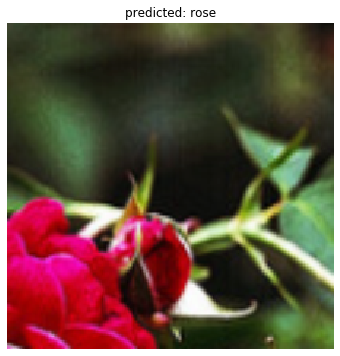

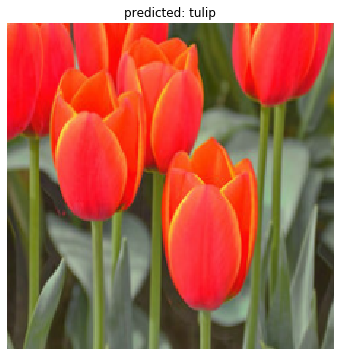

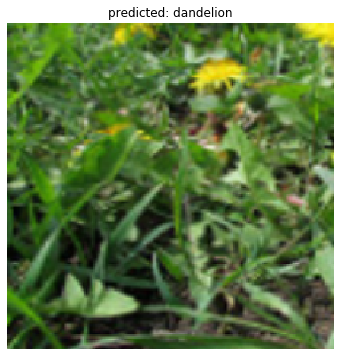

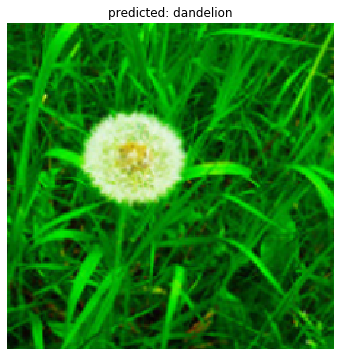

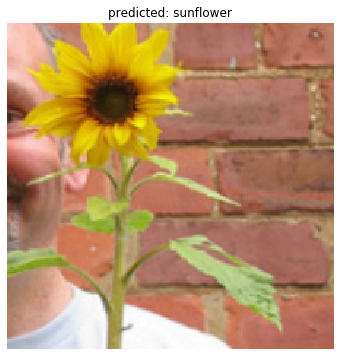

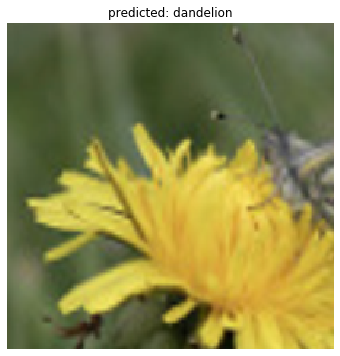

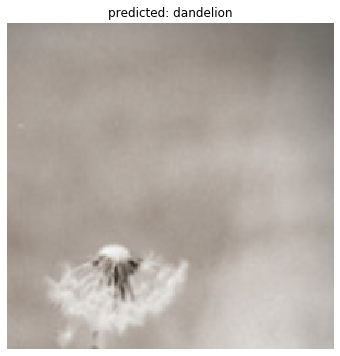

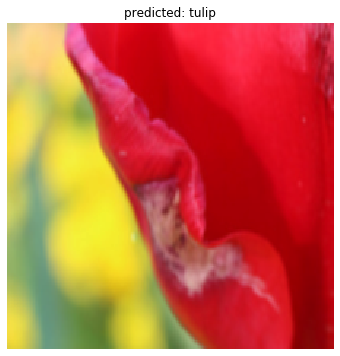

In [75]:
with torch.no_grad():
    
    inputs, labels = iter(dataloader['test']).next()
    inp = torchvision.utils.make_grid(inputs)
    
    
    outputs = frozen_model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        image_show(inp, 'predicted: ' + class_name[preds[j]])